In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from category_encoders.target_encoder import TargetEncoder
from scipy.stats import norm , skew
from  scipy import stats
from scipy.special import boxcox
import os 
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import fbeta_score, recall_score, precision_score, average_precision_score, precision_recall_curve
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE ,ADASYN,BorderlineSMOTE
from imblearn.under_sampling import NearMiss
import seaborn as sns
from collections import Counter
from sklearn.metrics import make_scorer
from time import time
import lightgbm as light
import catboost as cat
import xgboost as xgb
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler 

In [4]:
import numpy as np
import pandas as pd
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder, LabelEncoder,StandardScaler
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.mode.chained_assignment = None
import warnings
from sklearn import model_selection
from sklearn.model_selection import train_test_split,learning_curve,cross_val_score,KFold,TimeSeriesSplit,GridSearchCV
from sklearn.utils import resample
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
                              RandomForestClassifier, RandomForestRegressor,AdaBoostClassifier) 
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import metrics
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.svm import SVC
import lightgbm as lgbm
from sklearn.metrics import f1_score, confusion_matrix,roc_auc_score

In [6]:
os.getcwd()

'C:\\Users\\johnn\\玉山資料'

### import data

In [40]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
submit = pd.read_csv('./submission_test.csv')

### solve the index

In [41]:
train_index = pd.DataFrame(train['txkey'])
test_index = pd.DataFrame(test['txkey'])

### concat train test into data all

In [42]:
data = pd.concat([train,test],axis=0,sort=False)

# preprocessing

### fillna

In [43]:
data['flbmk'].fillna('N', inplace=True)
data['flg_3dsmk'].fillna('N', inplace=True)

### cross feature

In [44]:
data['ecfg_stocn'] = data['ecfg'] + data['stocn'].astype('str')
data['ecfg_scity'] = data['ecfg'] + data['scity'].astype('str')

data['ovrlt_stocn'] = data['ovrlt'] + data['stocn'].astype('str')
data['ovrlt_scity'] = data['ovrlt'] + data['stocn'].astype('str')

### category to num

In [45]:
data['ecfg'] = data['ecfg'].astype('category').cat.codes
data['flbmk'] = data['flbmk'].astype('category').cat.codes
data['flg_3dsmk'] = data['flg_3dsmk'].astype('category').cat.codes
data['insfg'] = data['insfg'].astype('category').cat.codes
data['ovrlt'] = data['ovrlt'].astype('category').cat.codes
# #數值
data['acqic'] = data['acqic'].astype('category').cat.codes
data['bacno'] = data['bacno'].astype('category').cat.codes
data['cano'] = data['cano'].astype('category').cat.codes
data['csmcu'] = data['csmcu'].astype('category').cat.codes
data['hcefg'] = data['hcefg'].astype('category').cat.codes
data['mcc'] = data['mcc'].astype('category').cat.codes
data['mchno'] = data['mchno'].astype('category').cat.codes
data['scity'] = data['scity'].astype('category').cat.codes
data['stocn'] = data['stocn'].astype('category').cat.codes

In [46]:
data['ecfg'] = data['ecfg'].astype('category').cat.codes

In [47]:
data['ecfg']

0         0
1         0
2         0
3         0
4         0
         ..
421660    0
421661    0
421662    0
421663    0
421664    0
Name: ecfg, Length: 1943452, dtype: int8

### loctm data

In [49]:
data['loctm_int'] = data['loctm'].astype(int)
data['loctm_str'] = data['loctm_int'].astype(str)
data['loctm_str'] = data['loctm_str'].apply(lambda x : '0'+x if (len(x)==5) else ('00'+x if (len(x)==4) else ('000'+x if (len(x)==3) else ('0000'+x if (len(x)==2) else ('00000'+x if (len(x)==1) else x)))))
data['hours'] = data['loctm_str'].str[0:2]
data['minutes'] = data['loctm_str'].str[2:4]
data['seconds'] = data['loctm_str'].str[4:6]
data['hours'] = data['hours'].astype(int)
data['minutes'] = data['minutes'].astype(int)
data['seconds'] = data['seconds'].astype(int)
data['total_seconds'] = data['locdt']*86400+data['hours']*3600+data['minutes']*60+data['seconds']
data['time'] = (data['hours']*3600+data['minutes']*60+data['seconds'])#/86400

data['trad_hour'] = data['loctm'] // 10000

data['morning'] = ((data['trad_hour'] < 12) & (data['trad_hour'] >=6)).replace([True,False],[1,0])
data['afternoon'] = ((data['trad_hour'] < 18) & (data['trad_hour'] >=12)).replace([True,False],[1,0])
data['night'] = ((data['trad_hour'] < 24) & (data['trad_hour'] >=18)).replace([True,False],[1,0])
data['midnight'] = ((data['trad_hour'] < 6) & (data['trad_hour'] >=0)).replace([True,False],[1,0])

### account data

In [50]:
transation_count = data.groupby(['bacno'])['cano'].count().rename("transation_count").reset_index()
data = data.merge(transation_count,how='left')

transation_count_cano = data.groupby(['bacno','cano'])['cano'].count().rename("transation_count_cano").reset_index()
data = data.merge(transation_count_cano,how='left')

acqic_duplicated_count = data.groupby(['bacno','acqic'])['acqic'].count().rename("acqic_duplicated_count").reset_index()
data = data.merge(acqic_duplicated_count,how='left')

conam_duplicated_count = data.groupby(['bacno','conam'])['conam'].count().rename("conam_duplicated_count").reset_index()
data = data.merge(conam_duplicated_count,how='left')

conam_stocn = data.groupby(['csmcu','stocn'])['stocn'].count().rename("conam_stocn").reset_index()
data = data.merge(conam_stocn, on=['csmcu', 'stocn'])

bacno_mchno = data.groupby(['bacno','mchno'])['mchno'].count().rename("bacno_mchno").reset_index()
data = data.merge(bacno_mchno, on=['bacno', 'mchno'])

cano_mchno = data.groupby(['cano','mchno'])['mchno'].count().rename("cano_mchno").reset_index()
data = data.merge(cano_mchno, on=['cano', 'mchno'])

bacno_stocn = data.groupby(['bacno','stocn'])['stocn'].count().rename("bacno_stocn").reset_index()
data = data.merge(bacno_stocn, on=['bacno', 'stocn'])

cano_stocn = data.groupby(['cano','stocn'])['stocn'].count().rename("cano_stocn").reset_index()
data = data.merge(cano_stocn, on=['cano', 'stocn'])

bacno_scity = data.groupby(['bacno','scity'])['scity'].count().rename("bacno_scity").reset_index()
data = data.merge(bacno_scity, on=['bacno', 'scity'])

cano_scity = data.groupby(['cano','scity'])['scity'].count().rename("cano_scity").reset_index()
data = data.merge(cano_scity, on=['cano', 'scity'])


bacno_flg_3dsmk = data.groupby(['bacno','flg_3dsmk'])['flg_3dsmk'].count().rename("bacno_flg_3dsmk").reset_index()
data = data.merge(bacno_flg_3dsmk, on=['bacno', 'flg_3dsmk'])

cano_flg_3dsmk = data.groupby(['cano','flg_3dsmk'])['flg_3dsmk'].count().rename("cano_flg_3dsmk").reset_index()
data = data.merge(cano_flg_3dsmk, on=['cano', 'flg_3dsmk'])


bacno_ecfg_mean = data.groupby(['bacno'])['ecfg'].mean().rename("bacno_ecfg_mean").reset_index()
data = data.merge(bacno_ecfg_mean, on=['bacno'])

cano_ecfg_mean = data.groupby(['cano'])['ecfg'].mean().rename("cano_ecfg_mean").reset_index()
data = data.merge(cano_ecfg_mean, on=['cano'])

grp = data.groupby(['bacno'])['conam'].min().rename("comsum_min").reset_index()
data = data.merge(grp,how='left')

grp = data.groupby(['bacno'])['conam'].max().rename('comsum_max').reset_index()
data = data.merge(grp,how='left')

grp = (data.groupby(['bacno'])['txkey'].count() / data['locdt'].max()).reset_index().rename(columns={'txkey':'acc_trad_ave'})
data = data.merge(grp,how='left')

grp = data.groupby(['bacno'])['txkey'].count().reset_index().rename(columns={'txkey':'acc_trad_total'})
data = data.merge(grp,how='left')

grp = data.groupby(['bacno'])['conam'].sum().reset_index().rename(columns={'conam':'comsum_total'})
data = data.merge(grp,how='left')

grp = data.groupby(['bacno'])['conam'].mean().reset_index().rename(columns={'conam':'comsum_ave'})
data = data.merge(grp,how='left')

mean_amount = data.groupby(['bacno'])['conam'].mean().rename("mean_amount").reset_index()
data = data.merge(mean_amount,how='left')

data['amtby_mean_amount'] = data['conam'] / data['mean_amount']
data['amtby_mean_amount'] = data['amtby_mean_amount'].fillna(0)

mean_amount_cano = data.groupby(['bacno','cano'])['conam'].mean().rename("mean_amount_cano").reset_index()
data = data.merge(mean_amount_cano,how='left')

data['amtby_mean_amount_cano'] = data['conam'] / data['mean_amount_cano']
data['amtby_mean_amount_cano'] = data['amtby_mean_amount_cano'].fillna(0)


median_amount = data.groupby(['bacno'])['conam'].median().rename("median_amount").reset_index()
data = data.merge(median_amount,how='left')

data['amtby_median_amount'] = data['conam'] / data['median_amount']
data['amtby_median_amount'] = data['amtby_median_amount'].fillna(0)

median_amount_cano = data.groupby(['bacno','cano'])['conam'].median().rename("median_amount_cano").reset_index()
data = data.merge(median_amount_cano,how='left')

data['amtby_median_amount_cano'] = data['conam'] / data['median_amount_cano']
data['amtby_median_amount_cano'] = data['amtby_median_amount_cano'].fillna(0)

std_amount = data.groupby(['bacno'])['conam'].std().rename("std_amount").reset_index()
data = data.merge(std_amount,how='left')

### time series

In [51]:
day30 = data[data['locdt'] <= 30]
grp = (day30.groupby(['bacno'])['txkey'].count() / 30).reset_index().rename(columns={'txkey':'comsum_feq30'})
data = data.merge(grp,how='left')
data['comsum_feq30'].fillna(0,inplace=True)

day30 = data[(data['locdt'] <= 60) & (data['locdt'] >30 ) ]
grp = (day30.groupby(['bacno'])['txkey'].count() / 30).reset_index().rename(columns={'txkey':'comsum_feq3060'})
data = data.merge(grp,how='left')
data['comsum_feq3060'].fillna(0,inplace=True)

day30 = data[(data['locdt'] <= 90) & (data['locdt'] >60 ) ]
grp = (day30.groupby(['bacno'])['txkey'].count() / 30).reset_index().rename(columns={'txkey':'comsum_feq6090'})
data = data.merge(grp,how='left')
data['comsum_feq6090'].fillna(0,inplace=True)

day30 = data[(data['locdt'] <= 120) & (data['locdt'] >90 ) ]
grp = (day30.groupby(['bacno'])['txkey'].count() / 30).reset_index().rename(columns={'txkey':'comsum_feq90120'})
data = data.merge(grp,how='left')
data['comsum_feq90120'].fillna(0,inplace=True)

day60 = data[data['locdt'] <= 60]
grp = (day60.groupby(['bacno'])['txkey'].count() / 60).reset_index().rename(columns={'txkey':'comsum_feq60'})
data = data.merge(grp,how='left')
data['comsum_feq60'].fillna(0,inplace=True)

day60 = data[(data['locdt'] <= 90) & (data['locdt'] >30 ) ]
grp = (day60.groupby(['bacno'])['txkey'].count() / 60).reset_index().rename(columns={'txkey':'comsum_feq3090'})
data = data.merge(grp,how='left')
data['comsum_feq3090'].fillna(0,inplace=True)

day60 = data[(data['locdt'] <= 120) & (data['locdt'] >60 ) ]
grp = (day60.groupby(['bacno'])['txkey'].count() / 60).reset_index().rename(columns={'txkey':'comsum_feq60120'})
data = data.merge(grp,how='left')
data['comsum_feq60120'].fillna(0,inplace=True)

grp = data.groupby(['locdt'])['bacno'].count().reset_index().rename(columns={'bacno':'day_trad_num'})
data = data.merge(grp,how='left')

grp = data.groupby(['locdt'])['conam'].sum().reset_index().rename(columns={'conam':'day_comsum_total'})
data = data.merge(grp,how='left')


frequency = ((data.groupby(['bacno'])['locdt'].max()-data.groupby(['bacno'])['locdt'].min())/data.groupby(['bacno'])['locdt'].count()).rename("frequency").reset_index()
data = data.merge(frequency,how='left')

frequency_cano = ((data.groupby(['bacno','cano'])['locdt'].max()-data.groupby(['bacno','cano'])['locdt'].min())/data.groupby(['bacno','cano'])['locdt'].count()).rename("frequency_cano").reset_index()
data = data.merge(frequency_cano,how='left')

mean_time = data.groupby(['bacno'])['time'].mean().rename("mean_time").reset_index()
data = data.merge(mean_time,how='left')

median_time = data.groupby(['bacno'])['time'].median().rename("median_time").reset_index()
data = data.merge(median_time,how='left')


mean_time_cano = data.groupby(['bacno','cano'])['time'].mean().rename("mean_time_cano").reset_index()
data = data.merge(mean_time_cano,how='left')

median_time_cano = data.groupby(['bacno','cano'])['time'].median().rename("median_time_cano").reset_index()
data = data.merge(median_time_cano,how='left')

data = data.sort_values(by = ['total_seconds'])
data['total_seconds_diff'] = data.groupby(['bacno'])['total_seconds'].diff()
data['total_seconds_diff'] = data['total_seconds_diff'].fillna(0)

data = data.sort_values(by = ['total_seconds'])
data['total_seconds_diff_cano'] = data.groupby(['bacno','cano'])['total_seconds'].diff()
data['total_seconds_diff_cano'] = data['total_seconds_diff_cano'].fillna(0)


data['date_day'] = data['locdt'] % 30

data['week'] = data['locdt'] % 7

data['2_week'] = data['locdt'] % 14

data['month'] = data['locdt'] % 30

### country data

In [52]:
data['is_taiwan'] = (data['stocn'] == 102).replace([True,False],[1,0])

grp = data.groupby(['stocn'])['txkey'].count().reset_index().rename(columns={'txkey':'country_com_num'})
data = data.merge(grp,how='left')

grp = data.groupby(['scity'])['txkey'].count().reset_index().rename(columns={'txkey':'city_com_num'})
data = data.merge(grp,how='left')

### target encoding

In [92]:
object_list = []
for col in data.columns.tolist():
    if data[col].dtype == 'object':
        object_list.append(col)
        
nd_tar_list = []
for col in object_list:

    if len(data[col].unique()) < 5:
        nd_ont_list.append(col)
    else:
        nd_tar_list.append(col)

In [94]:
object_list

['ecfg_stocn', 'ecfg_scity', 'ovrlt_stocn', 'ovrlt_scity', 'loctm_str']

In [54]:
train = data.merge(train_index)
test = data.merge(test_index)

In [55]:
train_tar = train[train['locdt'] > 30]

tar = TargetEncoder(smoothing=0.9).fit(train_tar[nd_tar_list],train_tar['fraud_ind'])
test[nd_tar_list] = tar.transform(test[nd_tar_list])
train[nd_tar_list] = tar.transform(train[nd_tar_list])

### check train test shape

In [56]:
test.drop('fraud_ind',axis=1,inplace=True)
print(train.shape,test.shape)

(1521787, 93) (421665, 92)


### build model (lightgbm)

In [57]:
lig_model = light.LGBMClassifier(
    n_estimators=700,reg_alpha=0.3,num_leaves=200,learning_rate=0.1,reg_lambda=0.5,subsample=0.7,is_unbalance=True)

In [58]:
X_train , X_valid , y_train ,y_valid = train_test_split(
    train.drop(['cano','bacno','fraud_ind','txkey'],axis=1),train['fraud_ind'],test_size=0.25,random_state =1102)

In [81]:
def cus_f1(ytru, ypre):
    threshold = 0.5
    y_pre = list(map(lambda item:int(item>threshold),ypre))
    f1 = f1_score(ytru, y_pre, average='macro')
    return 'f1', f1, True

In [82]:
clf = lig_model.fit(X_train,y_train
                    ,eval_set=[(X_train, y_train),(X_valid,y_valid)],
                            eval_metric=cus_f1,
                            early_stopping_rounds=100)

[1]	training's binary_logloss: 0.0834554	training's f1: 0.738217	valid_1's binary_logloss: 0.0854415	valid_1's f1: 0.730862
[2]	training's binary_logloss: 0.0794888	training's f1: 0.739484	valid_1's binary_logloss: 0.081908	valid_1's f1: 0.731541
[3]	training's binary_logloss: 0.0747238	training's f1: 0.741275	valid_1's binary_logloss: 0.0775116	valid_1's f1: 0.733513
[4]	training's binary_logloss: 0.0708456	training's f1: 0.743281	valid_1's binary_logloss: 0.0738734	valid_1's f1: 0.735136
[5]	training's binary_logloss: 0.0672539	training's f1: 0.745492	valid_1's binary_logloss: 0.0704401	valid_1's f1: 0.737124
[6]	training's binary_logloss: 0.0643663	training's f1: 0.748194	valid_1's binary_logloss: 0.0676192	valid_1's f1: 0.739807
[7]	training's binary_logloss: 0.0616472	training's f1: 0.751683	valid_1's binary_logloss: 0.0650308	valid_1's f1: 0.742784
[8]	training's binary_logloss: 0.0589693	training's f1: 0.756155	valid_1's binary_logloss: 0.0625829	valid_1's f1: 0.746956
[9]	train

[67]	training's binary_logloss: 0.0129868	training's f1: 0.920815	valid_1's binary_logloss: 0.0201452	valid_1's f1: 0.887722
[68]	training's binary_logloss: 0.0127405	training's f1: 0.922052	valid_1's binary_logloss: 0.0199442	valid_1's f1: 0.889317
[69]	training's binary_logloss: 0.0125073	training's f1: 0.923237	valid_1's binary_logloss: 0.0197369	valid_1's f1: 0.889839
[70]	training's binary_logloss: 0.0122645	training's f1: 0.924791	valid_1's binary_logloss: 0.0195411	valid_1's f1: 0.890797
[71]	training's binary_logloss: 0.01205	training's f1: 0.925541	valid_1's binary_logloss: 0.0193864	valid_1's f1: 0.89163
[72]	training's binary_logloss: 0.0118238	training's f1: 0.927233	valid_1's binary_logloss: 0.019195	valid_1's f1: 0.892596
[73]	training's binary_logloss: 0.0116214	training's f1: 0.928213	valid_1's binary_logloss: 0.0190456	valid_1's f1: 0.893321
[74]	training's binary_logloss: 0.0114233	training's f1: 0.929073	valid_1's binary_logloss: 0.0189246	valid_1's f1: 0.894182
[75]

[133]	training's binary_logloss: 0.00455717	training's f1: 0.972798	valid_1's binary_logloss: 0.0140837	valid_1's f1: 0.920618
[134]	training's binary_logloss: 0.00449694	training's f1: 0.973318	valid_1's binary_logloss: 0.0140486	valid_1's f1: 0.920722
[135]	training's binary_logloss: 0.00443819	training's f1: 0.973795	valid_1's binary_logloss: 0.0140133	valid_1's f1: 0.920836
[136]	training's binary_logloss: 0.00437637	training's f1: 0.974393	valid_1's binary_logloss: 0.0139814	valid_1's f1: 0.921164
[137]	training's binary_logloss: 0.00431012	training's f1: 0.974917	valid_1's binary_logloss: 0.0139402	valid_1's f1: 0.921439
[138]	training's binary_logloss: 0.00425114	training's f1: 0.975397	valid_1's binary_logloss: 0.0138987	valid_1's f1: 0.921526
[139]	training's binary_logloss: 0.00419776	training's f1: 0.975742	valid_1's binary_logloss: 0.0138617	valid_1's f1: 0.921821
[140]	training's binary_logloss: 0.00413913	training's f1: 0.976209	valid_1's binary_logloss: 0.013833	valid_1'

[198]	training's binary_logloss: 0.00185062	training's f1: 0.99375	valid_1's binary_logloss: 0.0124351	valid_1's f1: 0.932601
[199]	training's binary_logloss: 0.00182698	training's f1: 0.993847	valid_1's binary_logloss: 0.0124222	valid_1's f1: 0.932294
[200]	training's binary_logloss: 0.00179933	training's f1: 0.994089	valid_1's binary_logloss: 0.0123963	valid_1's f1: 0.932282
[201]	training's binary_logloss: 0.00177476	training's f1: 0.994348	valid_1's binary_logloss: 0.0123884	valid_1's f1: 0.932391
[202]	training's binary_logloss: 0.00175253	training's f1: 0.994494	valid_1's binary_logloss: 0.0123734	valid_1's f1: 0.932568
[203]	training's binary_logloss: 0.00173058	training's f1: 0.994656	valid_1's binary_logloss: 0.0123562	valid_1's f1: 0.932621
[204]	training's binary_logloss: 0.00171095	training's f1: 0.99477	valid_1's binary_logloss: 0.012348	valid_1's f1: 0.932754
[205]	training's binary_logloss: 0.00168773	training's f1: 0.994997	valid_1's binary_logloss: 0.0123384	valid_1's 

[263]	training's binary_logloss: 0.000819445	training's f1: 0.999157	valid_1's binary_logloss: 0.0118703	valid_1's f1: 0.937124
[264]	training's binary_logloss: 0.000810367	training's f1: 0.999173	valid_1's binary_logloss: 0.0118656	valid_1's f1: 0.937301
[265]	training's binary_logloss: 0.000801223	training's f1: 0.999239	valid_1's binary_logloss: 0.0118573	valid_1's f1: 0.937698
[266]	training's binary_logloss: 0.000792727	training's f1: 0.999289	valid_1's binary_logloss: 0.0118511	valid_1's f1: 0.937917
[267]	training's binary_logloss: 0.000783065	training's f1: 0.999322	valid_1's binary_logloss: 0.0118513	valid_1's f1: 0.937686
[268]	training's binary_logloss: 0.000774421	training's f1: 0.999322	valid_1's binary_logloss: 0.0118454	valid_1's f1: 0.937663
[269]	training's binary_logloss: 0.000765015	training's f1: 0.999338	valid_1's binary_logloss: 0.0118413	valid_1's f1: 0.937894
[270]	training's binary_logloss: 0.000757186	training's f1: 0.999355	valid_1's binary_logloss: 0.0118381

[328]	training's binary_logloss: 0.000412542	training's f1: 0.999884	valid_1's binary_logloss: 0.0116982	valid_1's f1: 0.940362
[329]	training's binary_logloss: 0.000407885	training's f1: 0.999884	valid_1's binary_logloss: 0.0116949	valid_1's f1: 0.940362
[330]	training's binary_logloss: 0.000404391	training's f1: 0.999884	valid_1's binary_logloss: 0.0116984	valid_1's f1: 0.940489
[331]	training's binary_logloss: 0.000400647	training's f1: 0.999884	valid_1's binary_logloss: 0.0117026	valid_1's f1: 0.940637
[332]	training's binary_logloss: 0.000396833	training's f1: 0.999884	valid_1's binary_logloss: 0.0116933	valid_1's f1: 0.940722
[333]	training's binary_logloss: 0.000393346	training's f1: 0.999884	valid_1's binary_logloss: 0.011689	valid_1's f1: 0.940457
[334]	training's binary_logloss: 0.000389774	training's f1: 0.999884	valid_1's binary_logloss: 0.0116875	valid_1's f1: 0.940595
[335]	training's binary_logloss: 0.000386505	training's f1: 0.999884	valid_1's binary_logloss: 0.0116912	

[394]	training's binary_logloss: 0.000234961	training's f1: 1	valid_1's binary_logloss: 0.0117347	valid_1's f1: 0.942468
[395]	training's binary_logloss: 0.000233165	training's f1: 1	valid_1's binary_logloss: 0.0117326	valid_1's f1: 0.94267
[396]	training's binary_logloss: 0.00023123	training's f1: 1	valid_1's binary_logloss: 0.0117303	valid_1's f1: 0.942585
[397]	training's binary_logloss: 0.000229457	training's f1: 1	valid_1's binary_logloss: 0.0117279	valid_1's f1: 0.942511
[398]	training's binary_logloss: 0.000227451	training's f1: 1	valid_1's binary_logloss: 0.0117307	valid_1's f1: 0.94266
[399]	training's binary_logloss: 0.000225745	training's f1: 1	valid_1's binary_logloss: 0.0117336	valid_1's f1: 0.942766
[400]	training's binary_logloss: 0.00022417	training's f1: 1	valid_1's binary_logloss: 0.0117351	valid_1's f1: 0.942852
[401]	training's binary_logloss: 0.000222514	training's f1: 1	valid_1's binary_logloss: 0.0117392	valid_1's f1: 0.942649
[402]	training's binary_logloss: 0.0

fbeta score_train: 0.9999607807250336
recall_score_train: 1.0
precision_score_train: 0.9998039343833737
fbeta score: 0.9094962968707588
recall_score: 0.9276250741546371
precision_score: 0.8435533177486063

Classification report:

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    375390
         1.0       0.84      0.93      0.88      5057

    accuracy                           1.00    380447
   macro avg       0.92      0.96      0.94    380447
weighted avg       1.00      1.00      1.00    380447



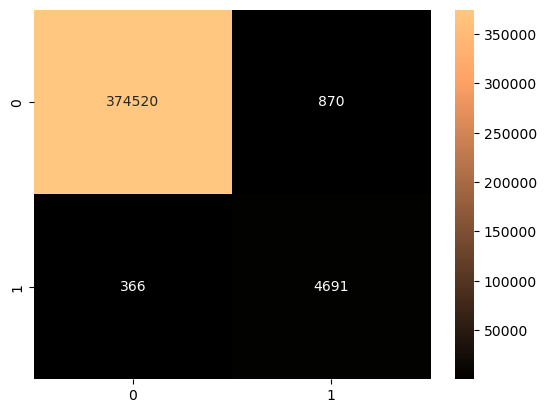

In [83]:
results = {}
results['ad'] = {}

pre_train = clf.predict(X_train)
pre_test = clf.predict(X_valid)

results['ad']['fbeta_train'] = fbeta_score(y_train, pre_train, beta=2)
results['ad']['recall_train'] = recall_score(y_train, pre_train)
results['ad']['precision_train'] = precision_score(y_train, pre_train)

results['ad']['fbeta_test'] = fbeta_score(y_valid, pre_test, beta=2)
results['ad']['recall_test'] = recall_score(y_valid, pre_test)
results['ad']['precision_test'] = precision_score(y_valid, pre_test)

print("fbeta score_train:", results['ad']['fbeta_train'])
print('recall_score_train:', results['ad']['recall_train'])
print('precision_score_train:', results['ad']['precision_train'])

print('========================================================')
print("fbeta score:", results['ad']['fbeta_test'])
print('recall_score:', results['ad']['recall_test'])
print('precision_score:', results['ad']['precision_test'])

# Classification report
print('\nClassification report:\n')
print(classification_report(y_valid, pre_test))

conf_matrix = confusion_matrix(y_valid, pre_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()


In [84]:
ypre = clf.predict(test.drop(['cano','bacno','txkey'],axis=1)) 
yh = clf.predict(test.drop(['cano','bacno','txkey'],axis=1),raw_score=True) 
yh = (yh > 2) * 1

In [85]:
ypre = pd.DataFrame(ypre,index=test.index) 
ypre = pd.concat([ypre,test['txkey']],axis=1) 
b = submit.merge(ypre)
yh = pd.DataFrame(yh,index=test.index) 
yh = pd.concat([yh,test['txkey']],axis=1) 
c = submit.merge(yh)

In [86]:
b[0].sum()

7375.0

In [87]:
c[0].sum()

4915

In [88]:
b = submit.merge(ypre)
b['fraud_ind'] = b[0]
b.drop(0,axis=1,inplace=True)
b.to_csv('test14.csv')
c = submit.merge(yh)
c['fraud_ind'] = c[0]
c.drop(0,axis=1,inplace=True)
c.to_csv('test15.csv')
imp = clf.feature_importances_
imp_col = X_train.columns.tolist()
importance = pd.DataFrame(imp,index=imp_col)
importance.sort_values(0,ascending=False)

,0
frequency_cano,2441
loctm_str,2138
seconds,2117
total_seconds,2013
std_amount,1952
...,...
mean_amount,0
month,0
is_taiwan,0
acc_trad_ave,0


In [98]:
importance.sort_values(0,ascending=False).to_csv("feature importance.csv")

In [89]:
data.columns

Index(['acqic', 'bacno', 'cano', 'conam', 'contp', 'csmcu', 'ecfg', 'etymd',
       'flbmk', 'flg_3dsmk', 'fraud_ind', 'hcefg', 'insfg', 'iterm', 'locdt',
       'loctm', 'mcc', 'mchno', 'ovrlt', 'scity', 'stocn', 'stscd', 'txkey',
       'ecfg_stocn', 'ecfg_scity', 'ovrlt_stocn', 'ovrlt_scity', 'loctm_int',
       'loctm_str', 'hours', 'minutes', 'seconds', 'total_seconds', 'time',
       'trad_hour', 'morning', 'afternoon', 'night', 'midnight',
       'transation_count', 'transation_count_cano', 'acqic_duplicated_count',
       'conam_duplicated_count', 'conam_stocn', 'bacno_mchno', 'cano_mchno',
       'bacno_stocn', 'cano_stocn', 'bacno_scity', 'cano_scity',
       'bacno_flg_3dsmk', 'cano_flg_3dsmk', 'bacno_ecfg_mean',
       'cano_ecfg_mean', 'comsum_min', 'comsum_max', 'acc_trad_ave',
       'acc_trad_total', 'comsum_total', 'comsum_ave', 'mean_amount',
       'amtby_mean_amount', 'mean_amount_cano', 'amtby_mean_amount_cano',
       'median_amount', 'amtby_median_amount', 'media

In [90]:
data.shape[0]

1943452